In [2]:
!pip install FlowCal

     |████████████████████████████████| 82 kB 278 kB/s eta 0:00:011
     |████████████████████████████████| 103 kB 7.5 MB/s eta 0:00:01
     |████████████████████████████████| 243 kB 8.2 MB/s eta 0:00:01
  Created wheel for FlowCal: filename=FlowCal-1.3.0-py3-none-any.whl size=84554 sha256=482a24ba38cb15cd776dc9f88ed0452898c66c8af0ac1da6bc6b88071015c595
  Stored in directory: /root/.cache/pip/wheels/59/b3/d2/c263ebe3ccd5e34236aeb7b9aa4285ecdb9e91587c9c959e2a
Successfully built FlowCal


In [3]:
### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib 
from matplotlib import pyplot as plt
import random

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
"""
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
"""
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import FlowCal
import keras
from keras.utils import Sequence
from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply, PReLU
from keras.models import Model, Sequential

from keras import backend as K
import tensorflow as tf

In [5]:
# Sort the file names
FCS_data = []
labels = []
data_dir = "/kaggle/input/samusik-scrna-data/"
for i in os.listdir(data_dir):
    if "csv" in i:
        labels.append(data_dir + i)
    elif "fcs" in i:
        FCS_data.append(data_dir + i)

FCS_data.sort()
labels.sort()
#print(FCS_data)
#print(labels)

In [ ]:
# Keras DataGenerator
# We use this to load the data as we need it every epoch

class DataGenerator(Sequence):
    
    """
    fcs_files = List of .fcs files in directory
    labels = list of .csv files in directory (sorted the same as fcs_files)
    batch_size = number of scRNA data points to consider in a batch
       DataGenerator will sample [batch_size/len(list_IDs)] samples from each fcs file
       Each file has ~87K samples
    n_classes = 25 (24 cells, 1 no cell type listed (0))    
    
    """
    def __init__(self, fcs_files, labels, batch_size=30000, n_classes=25, shuffle=True):
        self.n_features = 51 # Each sample has 51 features
        self.batch_size = batch_size
        self.labels = labels
        self.fcs_files = fcs_files
        self.n_classes = n_classes
        self.shuffle = shuffle
        
        # Make an index over all samples
        # self.length is an int for the total number of samples
        # self.indices is a list of ints that tell us which index belongs to what file
        self.length, self.indices = self.compute_length(labels)
        self.indexes = np.array([i for i in range(self.length)])
        self.on_epoch_end()
        
    def compute_length(self, labels):
        L = 0
        FL = []
        for l in labels:
            df = pd.read_csv(l)
            L = L + len(df)
            FL.append(L)
        return L, FL
            
    def __len__(self):
        return self.length // self.batch_size
    
    def __getitem__(self, index):
        
        X = np.zeros((self.batch_size, self.n_features))
        #y = np.zeros(self.batch_size)
        
        # start and end index X and y
        start = 0
        end = 0
        
        # Prev max indexes globally for all samples
        prev_max = 0
        
        # idx/index both hold the global sample indexes we want
        idx = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        # bin them according to files in which they reside
        for i, max_file_index in enumerate(self.indices):
            
            file_idx = idx[idx < max_file_index] - prev_max
            
            if len(file_idx) == 0:
                continue
                
            end = start + len(file_idx)
            #print(len(file_idx))
            
            # Read each fcs file to get the samples
            si = FlowCal.io.FCSData(self.fcs_files[i])
            si = np.arcsinh(si[file_idx])   
            X[start:end] = si 
        
            # Unnecessary for autoencoder
            # Read each csv to get the labels
            #file_labels = pd.read_csv(self.labels[i])["Population"].to_numpy()
            #y[start:end] = file_labels[file_idx]
        
            # Update the indexing
            start = end
            idx = idx[idx >= max_file_index]
            prev_max = max_file_index
            
        return X, X
    
    def on_epoch_end(self):
        
        if self.shuffle:
            np.random.shuffle(self.indexes)
        
# Split files for training, validation, testing
TrainDG = DataGenerator(FCS_data[:6], labels[:6])
ValidateDG = DataGenerator([FCS_data[7]], [labels[7]])
TestDG = DataGenerator([FCS_data[8]], [labels[8]])        
    

In [ ]:
"""
Build the simplest possible decoder & encoder
Feed Forward NN with 2 layers

"""
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = '42'

AE2layer = Sequential()
AE2layer.add(Dense(2, input_dim=51, activation="selu", name="encoder"))
AE2layer.add(Dense(51, activation="selu", name="decoder"))
AE2layer.compile(loss="mse", optimizer="adam", metrics=["mse"])

"""
history_2layer = AE2layer.fit(x=TrainDG, 
                              use_multiprocessing=True,
                              workers=-1,
                              epochs=20,
                              validation_data=ValidateDG)
"""
history_2layer = AE2layer.fit(s01, s01, 
                              use_multiprocessing=True,
                              workers=-1,
                              epochs=10)

In [ ]:
"""
Simplest FF Autoencoder metrics
It seems to overfit, makes sense that it does.
"""

plt.figure(1)
plt.plot(history_2layer.history["loss"])
#plt.plot(history_2layer.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("Mean Squared Error")
plt.legend(["Training MSE", "Validation MSE"])
plt.title("2 Layer Feed Forward AutoEncoder")
plt.savefig("2layerMetrics")

#AE2layer.evaluate(x=TestDG, use_multiprocessing=True, workers=-1)

In [ ]:
"""
Embeddings generated by simplest FF Model
"""
s01 = FlowCal.io.FCSData(FCS_data[0])
s01 = np.arcsinh(np.array(s01))

simple_encoder = AE2layer.get_layer("encoder")
s01_encoding = simple_encoder(s01)

labels = np.array(pd.read_csv(data_dir + "population_assignments01.csv")["Population"])
print(labels)

color_list = ["beige","violet","red","blue","lightsalmon", "cyan","orchid", "plum", 'olivedrab', 'palegreen', 'gold', 'tan', 'slategray','lemonchiffon', "paleturquoise","pink","crimson","orange","mediumvioletred","lightskyblue","navajowhite","sienna","springgreen","c","purple"]
cmap_own = matplotlib.colors.LinearSegmentedColormap.from_list("", color_list)

plt.figure(2)
plt.scatter(s01_encoding[:, 0], s01_encoding[:, 1], c = labels,s=5, alpha=0.4, cmap = cmap_own)
plt.xlabel("AE2Layer 1")
plt.ylabel("AE2Layer 2")
plt.title("Simple Autoencoder Embeddings for Samusik_01")
plt.savefig("2 layer AE embeddings samusik_01")

np.save("s01_2layer", s01_encoding)


In [ ]:
"""
Add a few layers to the network, see how it changes embeddings
Still a simple FF model

"""
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = '42'

AE6layer = Sequential()
AE6layer.add(Dense(20, input_dim=51, activation="selu", name="encoder1"))
AE6layer.add(Dense(10, activation="selu", name="encoder2"))
AE6layer.add(Dense(2, activation="selu", name="encoder3"))
AE6layer.add(Dense(10, activation="selu", name="decoder1"))
AE6layer.add(Dense(20, activation="selu", name="decoder2"))
AE6layer.add(Dense(51, activation="selu", name="decoder3"))
AE6layer.compile(loss="mse", optimizer="adam", metrics=["mse"])

"""
history_6layer = AE6layer.fit(x=TrainDG, 
                              use_multiprocessing=True,
                              workers=-1,
                              epochs=20,
                              validation_data=ValidateDG)
"""
history_6layer = AE6layer.fit(s01, s01,
                              use_multiprocessing=True,
                              workers=-1,
                              epochs=10)

In [ ]:
"""
6 layer FF Autoencoder metrics
It also seems to overfit, but it did much better than the 2 layer model.
"""

plt.figure(1)
plt.plot(history_6layer.history["loss"])
#plt.plot(history_6layer.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("Mean Squared Error")
plt.legend(["Training MSE", "Validation MSE"])
plt.title("6 Layer Feed Forward AutoEncoder")
plt.savefig("6layerMetrics")

#AE6layer.evaluate(x=TestDG, use_multiprocessing=True, workers=-1)

In [ ]:
"""
Embeddings generated by 6 layer
"""
s01 = FlowCal.io.FCSData(FCS_data[0])
s01 = np.arcsinh(np.array(s01))

e1 = AE6layer.get_layer("encoder1")
e2 = AE6layer.get_layer("encoder2")
e3 = AE6layer.get_layer("encoder3")
s01_encoding = e3(e2(e1(s01)))

labels = np.array(pd.read_csv(data_dir + "population_assignments01.csv")["Population"])
print(labels)

color_list = ["beige","violet","red","blue","lightsalmon", "cyan","orchid", "plum", 'olivedrab', 'palegreen', 'gold', 'tan', 'slategray','lemonchiffon', "paleturquoise","pink","crimson","orange","mediumvioletred","lightskyblue","navajowhite","sienna","springgreen","c","purple"]
cmap_own = matplotlib.colors.LinearSegmentedColormap.from_list("", color_list)

plt.figure()
plt.scatter(s01_encoding[:, 0], s01_encoding[:, 1], c = labels,s=5, alpha=0.4, cmap = cmap_own)
plt.xlabel("AE6Layer 1")
plt.ylabel("AE6Layer 2")
plt.title("6 layer Autoencoder Embeddings for Samusik_01")
plt.savefig("6 layer AE embeddings samusik_01")

np.save("s01_6layer", s01_encoding)

In [ ]:
samusik_all = pd.read_csv(data_dir + "samusik_concatenated.csv").to_numpy()
samusik_all = np.arcsinh(samusik_all)

In [6]:
s01 = FlowCal.io.FCSData(FCS_data[0])
s01 = np.arcsinh(np.array(s01))

def rec_loss(y_true, y_pred):
    """ Reconstruction error """

    return K.sum(K.square(y_true - y_pred))


class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = '42'    

stdev = 1
    
x = Input(shape=(51,), name="input")
E1 = Dense(20, activation="selu", name="E1")(x)
E2 = Dense(10, activation="selu", name="E2")(E1)
mu = Dense(2, activation="selu", name="mu")(E2)
log_var = Dense(2, activation="selu", name="log_var")(E2)

KL = KLDivergenceLayer(name="KL")([mu, log_var])
sigma = Lambda(lambda t: K.exp(.5*t), name="sigma")(log_var)

#eps = Input(tensor=K.random_normal(stddev=1.0,
#                                   shape=(K.shape(x)[0], 2)), name="eps")
#z_eps = Multiply(name="zeps")([sigma, eps])

z_eps = Multiply(name="z_eps")([sigma, K.random_normal(stddev=stdev,shape=(K.shape(x)[0], 2))])
z = Add(name="z")([mu, z_eps]) # not zeps

D1 = Dense(10, activation="selu", name="D1")(z)
D2 = Dense(20, activation="selu", name="D2")(D1)
D3 = Dense(51, activation="selu", name="D3")(D2)

VAE = Model(inputs=x, outputs=D3)
VAE.compile(loss=rec_loss, optimizer="adam", metrics=["mse"])

"""
VAE_history = VAE.fit(x=(s01, s01), 
                      use_multiprocessing=True,
                      workers=-1,
                      epochs=50,
                      shuffle=True,
                      validation_data=ValidateDG)
"""
VAE_history = VAE.fit(s01, s01,
                      use_multiprocessing=True,
                      workers=-1,
                      epochs=50,
                      #batch_size=100,
                      shuffle=True)
                      #validation_data=ValidateDG)

Epoch 1/50
2715/2715 [==============================] - 5s 2ms/step - loss: 5362.0653 - mse: 3.2856
Epoch 2/50
2715/2715 [==============================] - 4s 2ms/step - loss: 1911.9427 - mse: 1.1715
Epoch 3/50
2715/2715 [==============================] - 4s 2ms/step - loss: 1814.1815 - mse: 1.1116
Epoch 4/50
2715/2715 [==============================] - 4s 1ms/step - loss: 1778.1363 - mse: 1.0895
Epoch 5/50
2715/2715 [==============================] - 4s 2ms/step - loss: 1716.2809 - mse: 1.0516
Epoch 6/50
2715/2715 [==============================] - 4s 1ms/step - loss: 1660.2989 - mse: 1.0173
Epoch 7/50
2715/2715 [==============================] - 4s 2ms/step - loss: 1627.0165 - mse: 0.9969
Epoch 8/50
2715/2715 [==============================] - 4s 2ms/step - loss: 1603.4457 - mse: 0.9825
Epoch 9/50
2715/2715 [==============================] - 4s 2ms/step - loss: 1578.6651 - mse: 0.9673
Epoch 10/50
2715/2715 [==============================] - 4s 1ms/step - loss: 1569.3663 - mse: 0.9616

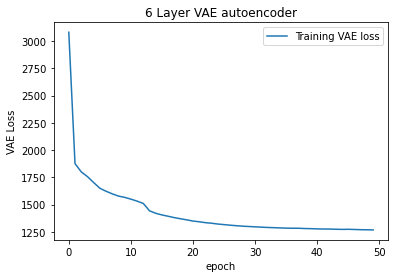

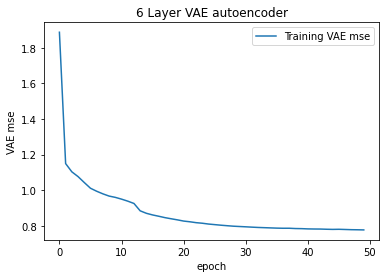

In [8]:
"""
6 layer VAE Autoencoder metrics
"""

plt.figure(1)
plt.plot(VAE_history.history["loss"])
#plt.plot(VAE_history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("VAE Loss")
plt.legend(["Training VAE loss", "Validation VAE loss"])
plt.title("6 Layer VAE autoencoder")
plt.savefig("VAELoss")

plt.figure(2)
plt.plot(VAE_history.history["mse"])
#plt.plot(VAE_history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("VAE mse")
plt.legend(["Training VAE mse", "Validation VAE mse"])
plt.title("6 Layer VAE autoencoder")
plt.savefig("VAEMSE")


#VAE.evaluate(x=TestDG, use_multiprocessing=True, workers=-1)

[20.  7.  0. ... 14.  8.  7.]


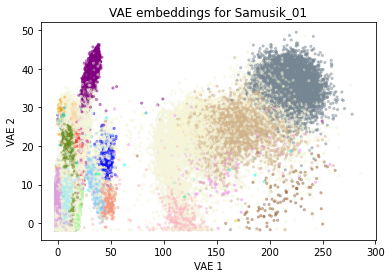

In [9]:
"""
Embeddings generated by VAE 6 layer
"""
s01 = FlowCal.io.FCSData(FCS_data[0])
s01 = np.arcsinh(np.array(s01))

e1 = VAE.get_layer("E1")
e2 = VAE.get_layer("E2")
e3 = VAE.get_layer("mu")
s01_mu = e3(e2(e1(s01)))

labels = np.array(pd.read_csv(data_dir + "population_assignments01.csv")["Population"])
print(labels)

color_list = ["beige","violet","red","blue","lightsalmon", "cyan","orchid", "plum", 'olivedrab', 'palegreen', 'gold', 'tan', 'slategray','lemonchiffon', "paleturquoise","pink","crimson","orange","mediumvioletred","lightskyblue","navajowhite","sienna","springgreen","c","purple"]
cmap_own = matplotlib.colors.LinearSegmentedColormap.from_list("", color_list)

plt.figure()
plt.scatter(s01_mu[:, 0], s01_mu[:, 1], c = labels,s=5, alpha=0.4, cmap = cmap_own)
plt.xlabel("VAE 1")
plt.ylabel("VAE 2")
plt.title("VAE embeddings for Samusik_01")
plt.savefig("VAE embeddings samusik_01")

np.save("s01_vae", s01_mu)

In [ ]:
#s01_hat = VAE(s01)
#print(s01[10, :10])
#print(s01_hat[10, :10])

print(np.max(s01))